In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
from load_dataset import *
import os

['/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils', '../utils', '../utils']


In [9]:
import yaml

config_path = '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/output/experiment_10/config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [10]:
import torch

# Save dir
save_dir = config['save_dir']
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# todo: multi nu
nu_list = config['nu_list']

# Data loader
x_dataset, u_dataset, nu_dataset = [], [], []
for i in range(len(nu_list)):
    nu = nu_list[i]
    config['data_dir'] = config['data_dir_list'][i]
    x_data, u_data, nu_data, n_features, n_inputs = data_preparation_xu(config, nu_list, nu)
    x_dataset.append(x_data)
    u_dataset.append(u_data)
    nu_dataset.append(nu_data)
    print(np.max(x_data))
    print(np.min(x_data))
    print(nu_data.shape)
    print(nu_data[1, :])

Device: cuda
2.251169363651072
-2.263121094224531
(7450, 3)
[1. 0. 0.]
6.742559001618681
-6.831994222487539
(7152, 3)
[0. 1. 0.]
8.593838849130764
-8.715203460430647
(7301, 3)
[0. 0. 1.]


In [11]:
from sklearn.preprocessing import StandardScaler
scaler_x_set = []
x_dataset_scaled = []
for x_data in x_dataset:
    scaler_x = StandardScaler()
    x_data = scaler_x.fit_transform(x_data)
    x_dataset_scaled.append(x_data)
    scaler_x_set.append(scaler_x)

In [12]:
x_data_scaled = np.concatenate(x_dataset_scaled, axis=0)
x_data_scaled.shape

(21903, 6957)

In [21]:
print(np.mean(x_data_scaled, axis=0))
print(np.std(x_data_scaled, axis=0))

[-9.38238058e-18 -4.73224771e-17 -2.54403934e-17 ...  5.63652469e-18
  2.31949074e-17  7.59308812e-18]
[1. 1. 1. ... 1. 1. 1.]


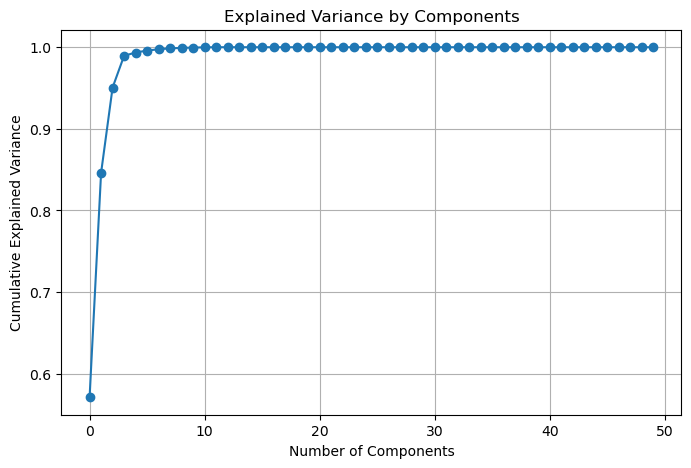

In [24]:
# 初始化PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=50)  # 选择一个初始的维度数目，例如100
x_pca = pca.fit_transform(x_data_scaled)

# 解释的方差比例
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 可视化累积解释方差
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# plt.yscale('log')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()


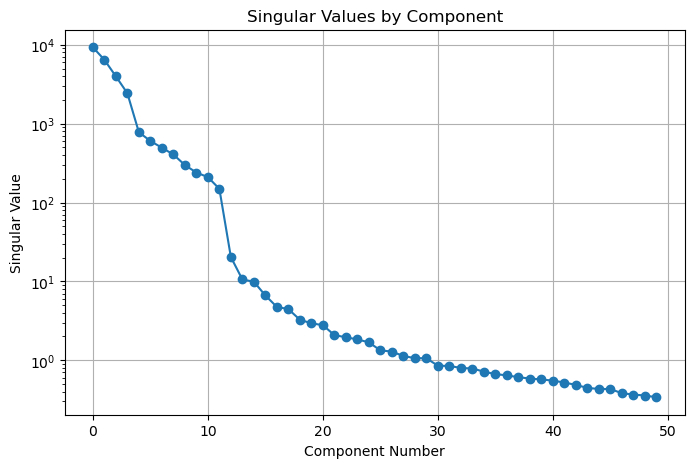

In [25]:
singular_values = pca.singular_values_

# Plot the singular values
plt.figure(figsize=(8, 5))
plt.plot(singular_values, marker='o')
plt.xlabel('Component Number')
plt.ylabel('Singular Value')
plt.title('Singular Values by Component')
plt.yscale('log')
plt.grid(True)
plt.show()

In [26]:
singular_values

array([9.32867520e+03, 6.47310666e+03, 3.99064928e+03, 2.43503407e+03,
       7.80857674e+02, 6.03274798e+02, 4.95875883e+02, 4.06688039e+02,
       2.99154735e+02, 2.39921299e+02, 2.10087463e+02, 1.49271516e+02,
       2.03368201e+01, 1.05638144e+01, 9.89533243e+00, 6.62472037e+00,
       4.73654628e+00, 4.44687439e+00, 3.26015185e+00, 2.93898393e+00,
       2.78111900e+00, 2.08104967e+00, 1.95392253e+00, 1.83538504e+00,
       1.68443099e+00, 1.33108168e+00, 1.28696170e+00, 1.12771818e+00,
       1.06365530e+00, 1.05646747e+00, 8.51667778e-01, 8.45521755e-01,
       7.96908487e-01, 7.84647570e-01, 7.15153457e-01, 6.65831247e-01,
       6.42550183e-01, 6.07991206e-01, 5.85546668e-01, 5.69584899e-01,
       5.50728507e-01, 5.20498224e-01, 4.86059340e-01, 4.44576012e-01,
       4.32106836e-01, 4.30811206e-01, 3.80520913e-01, 3.66895647e-01,
       3.56259713e-01, 3.39196122e-01])

In [27]:
cumulative_explained_variance

array([0.57110286, 0.84608211, 0.95059299, 0.98950508, 0.99350653,
       0.99589492, 0.99750861, 0.99859403, 0.99918134, 0.9995591 ,
       0.99984875, 0.99999497, 0.99999769, 0.99999842, 0.99999906,
       0.99999935, 0.9999995 , 0.99999963, 0.9999997 , 0.99999975,
       0.99999981, 0.99999983, 0.99999986, 0.99999988, 0.9999999 ,
       0.99999991, 0.99999992, 0.99999993, 0.99999994, 0.99999995,
       0.99999995, 0.99999995, 0.99999996, 0.99999996, 0.99999997,
       0.99999997, 0.99999997, 0.99999997, 0.99999998, 0.99999998,
       0.99999998, 0.99999998, 0.99999998, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999])

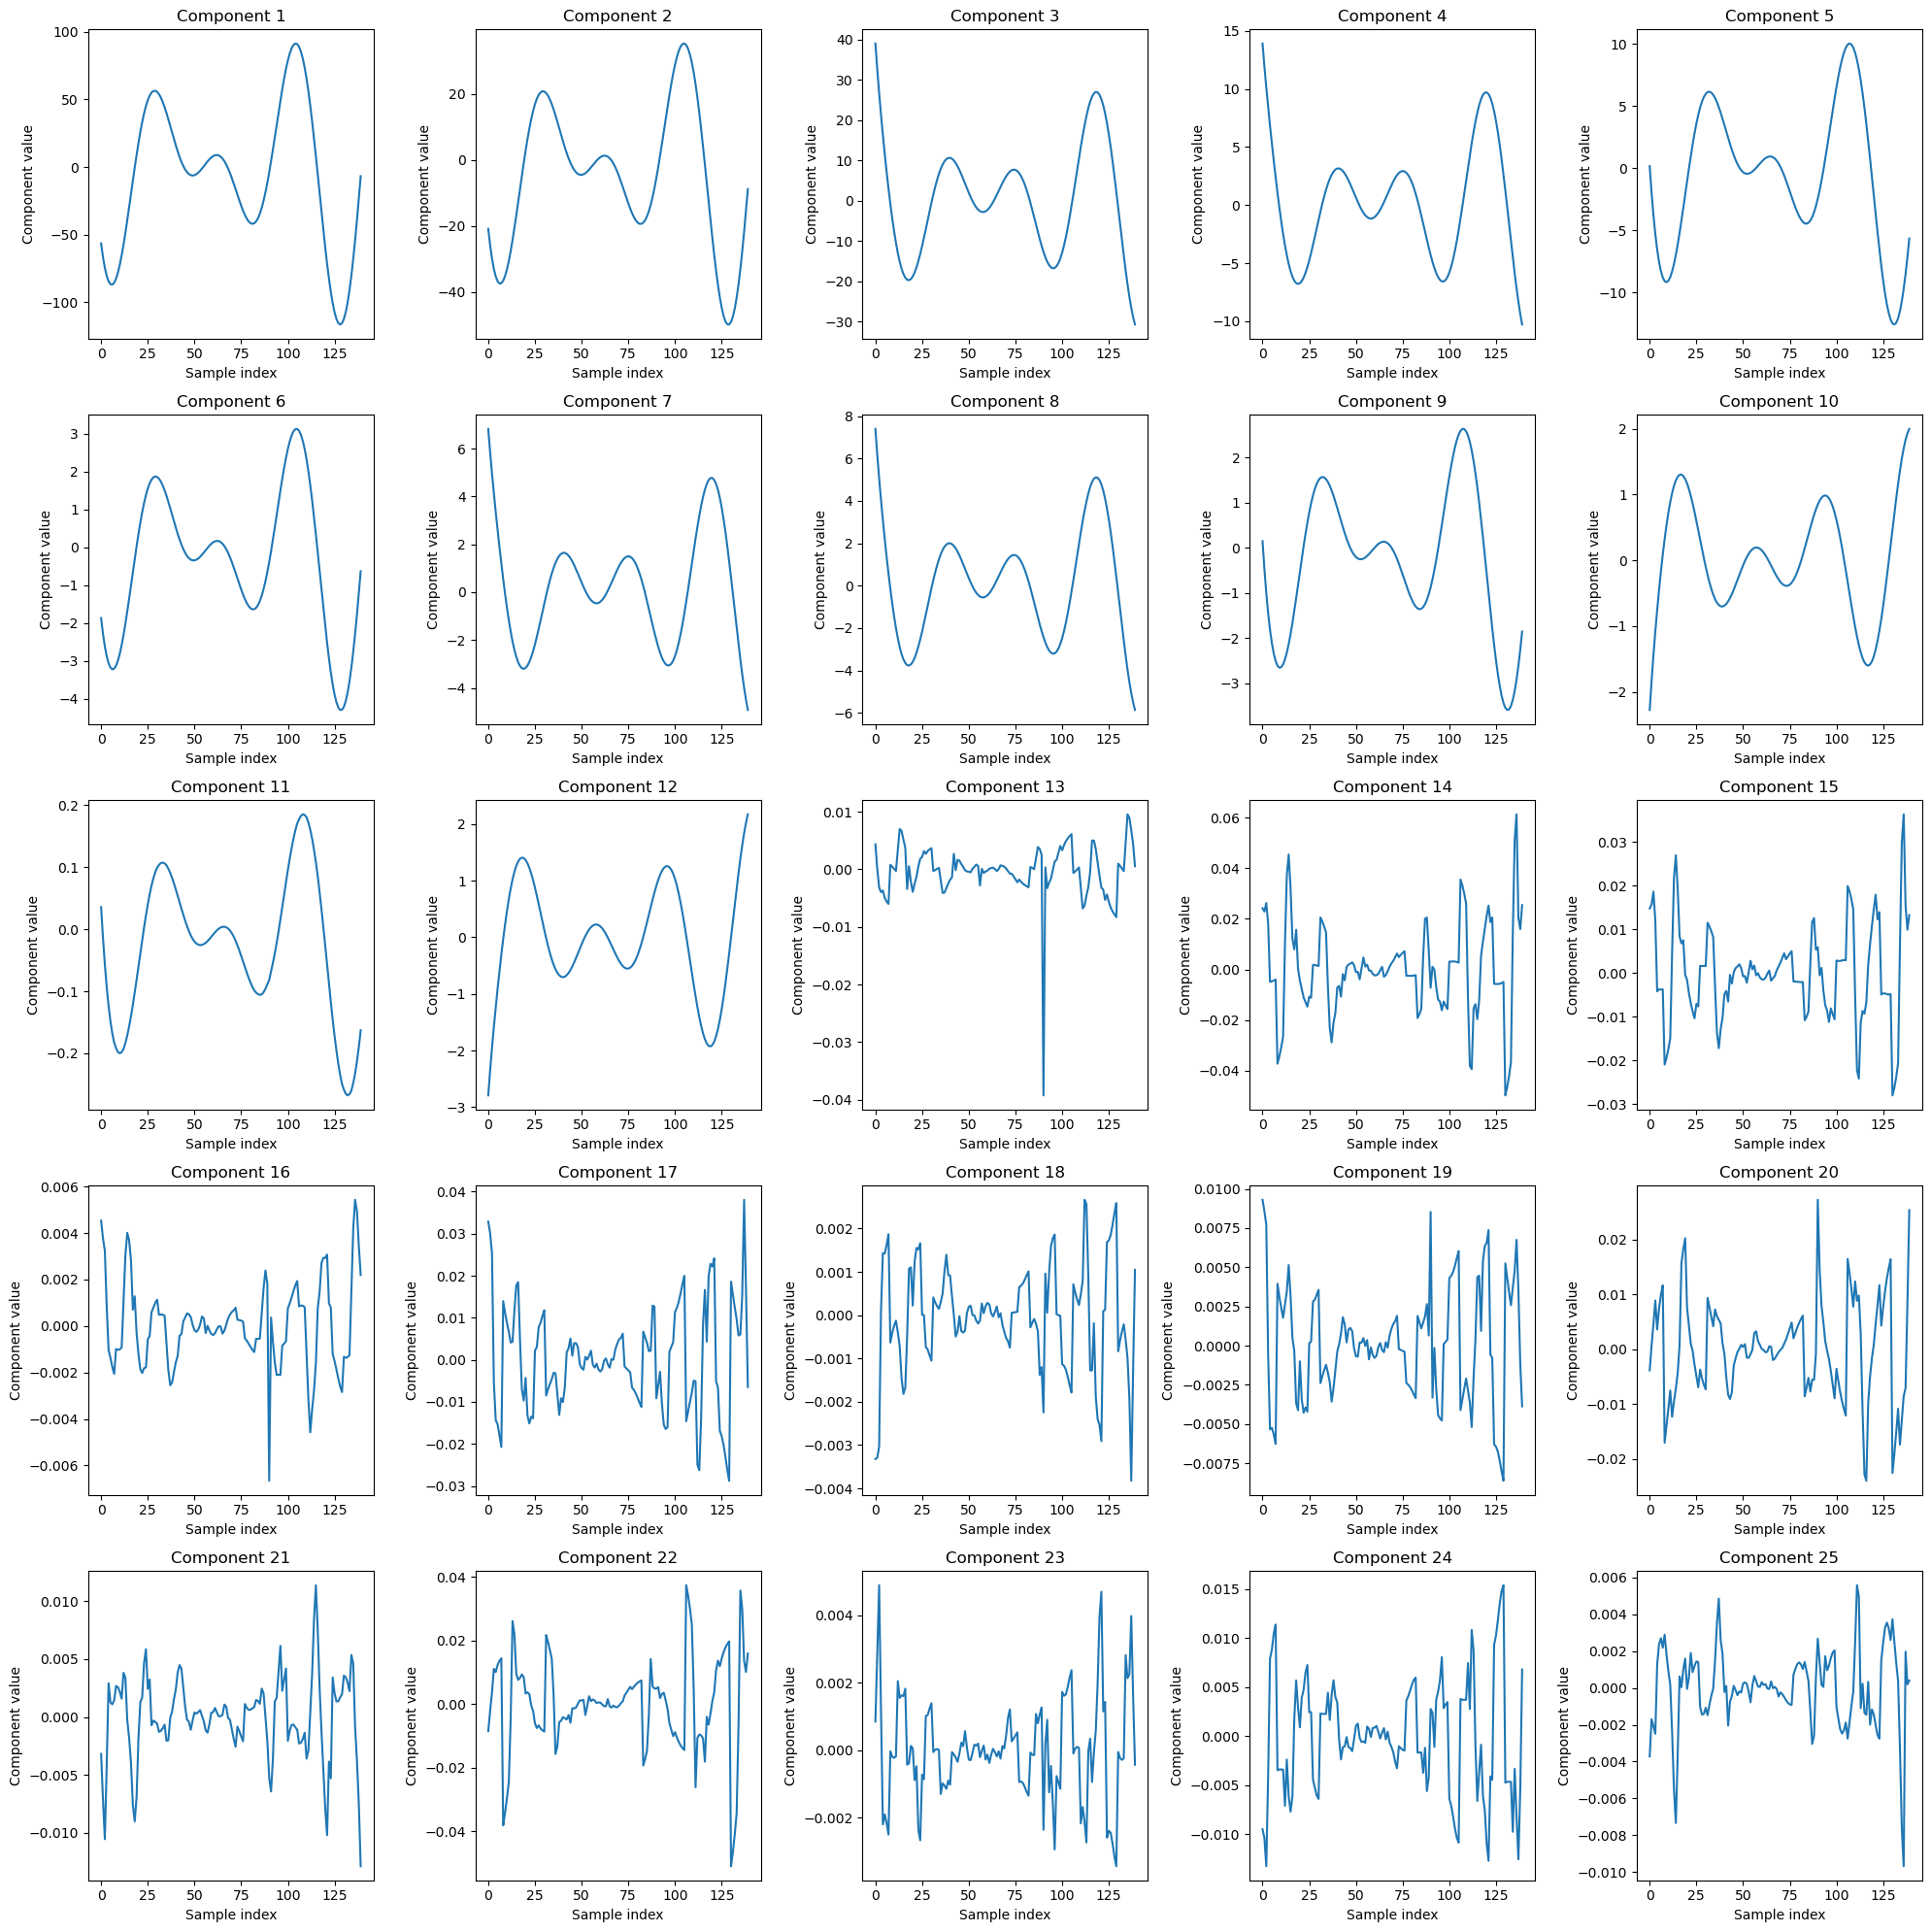

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plotting the first 150 samples of each PCA component in a row of 5 subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
for i in range(25):
    row = i // 5  # Determining the row of the subplot
    col = i % 5   # Determining the column of the subplot
    axes[row, col].plot(x_pca[:140, i])  # Corrected to plot with dots for clarity
    axes[row, col].set_title(f'Component {i+1}')
    axes[row, col].set_xlabel('Sample index')
    axes[row, col].set_ylabel('Component value')

plt.tight_layout()
plt.show()
